# Analyzing the spatio-temporal trajectory of single cells in mouse organogenesis with the SpatioTemporalProblem

In this tutorial, we show how to use the SpatioTemporalProblem to analyze the spatiotemporal trajectory in mouse organogenesis.


## Description of the dataset

The dataset is an extraction of the spatiotemporal transcriptomics atlas of the spatiotemporal transcriptomics atlas of mouse organogenesis using DNA nanoball-patterned arrays. The anndata object includes read-outs at three time points with embryo sections E9.5 E2S1, E10.5 E2S1, E11.5 E1S2. The data was preprocessed by normalizing and log-transforming the counts.

## Importing packages and loading the data

In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import squidpy as sq

import moscot as mt
from moscot.problems.spatio_temporal import SpatioTemporalProblem
from moscot.datasets import mosta
import moscot.plotting as mpl

sc.logging.print_header()
print(f"moscot=={mt.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7
moscot==0.1


In [2]:
adata = mosta()

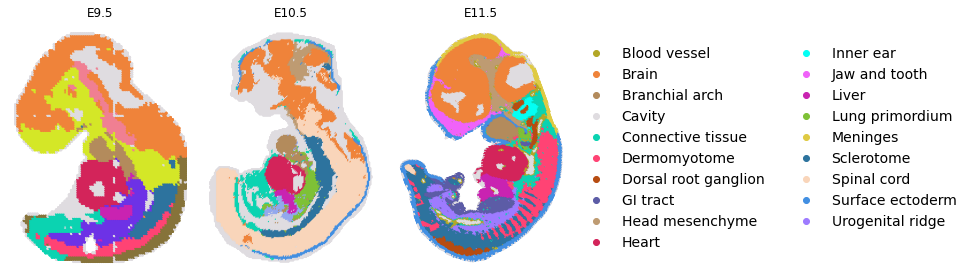

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(14,4))
for i, tp in enumerate(adata.obs["timepoint"].cat.categories):
    sq.pl.spatial_scatter(
        adata[adata.obs["timepoint"].isin([tp])].copy(), 
        color=["annotation"],
        title = [f"{tp}"],
        frameon=False,
        shape=None,
        library_id="hires",
        legend_fontsize = 14,
        ax=axs[i])
    if i < 2:
        axs[i].legend().remove()
    
plt.tight_layout()
plt.show()

We initialize and prepare the problem by specifying the `time_key` variable, which specifies the three different time points. Moreover, the `spatial_key` defines the key in `obsm` where the spatial coordinates are saved and the `joint_attr` defines where the single-cell data is stored. Here, we don't use a pre-computed embedding space but specify via `callback` that PCA should be run on `adata.X`. For the purpose of illustration we specifically specify the callback but this is not necessary.

In [4]:
stp = SpatioTemporalProblem(adata=adata)
stp = stp.prepare(
    time_key="time",
    spatial_key="spatial",
    joint_attr=None,
    callback="local-pca",
)


INFO     Computing pca with `n_comps=30` using `adata.X`                                     
INFO     Computing pca with `n_comps=30` using `adata.X`                                     


To solve the problem we specify `alpha`, which defines the influence (between 0 and 1) of the spatial coordinates as opposed to the single-cell data. We set `epsilon` to zero, which is only possible in low-rank cases. As the data is large, we use low rank to decrease computational complexity. `gamma` is a hyperparameter determining the step size of the low-rank solver. `max_iterations` is set relatively high, which allows the algorithm to take longer to converge. Finally, we use the `rank2` initializer to improve convergence.

In [5]:
stp = stp.solve(
    alpha=0.85, 
    epsilon=1e-3, 
    rank=500, 
    max_iterations=1000,
    initializer="rank2"
)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5870, 18292)].           
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(18292, 29972)].          


## Considering cell type transitions over time

We can now analyze which cell types are mapped to which cell type across time. As different time points have different cell types it is not straightforward to assess the mapping. To visualize the results nicely, we order the annotations such that in the upper left we have the same cell types.

In [6]:
celltypes_source_1 = adata[adata.obs["time"]==9.5].obs["annotation"].cat.categories
celltypes_target_1 = adata[adata.obs["time"]==10.5].obs["annotation"].cat.categories
celltypes_intersection_1 = list(set(celltypes_source_1).intersection(celltypes_target_1))
source_ordered_1 = celltypes_intersection_1 + list(set(celltypes_source_1) - set(celltypes_target_1))
target_ordered_1 = celltypes_intersection_1 + list(set(celltypes_target_1) - set(celltypes_source_1))

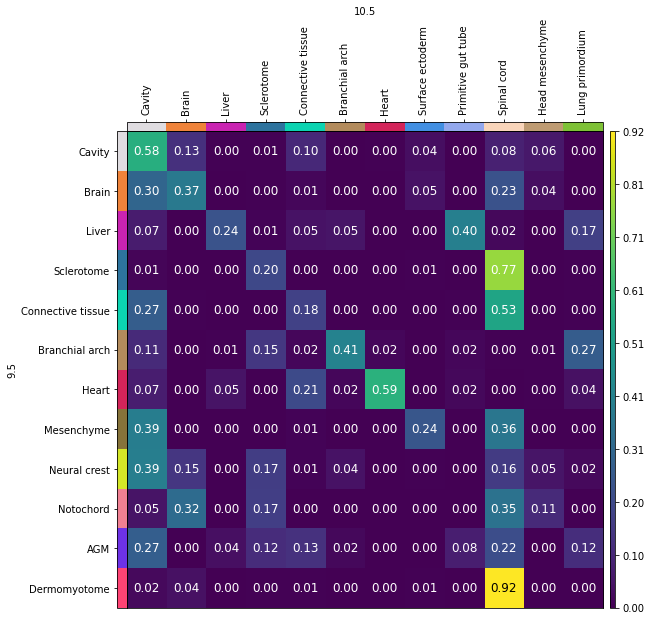

In [7]:
stp.cell_transition(source=9.5, target=10.5, source_groups={"annotation": source_ordered_1}, target_groups={"annotation": target_ordered_1}, forward=True)
mpl.cell_transition(stp, fontsize=12, figsize=(7,7))

All in all, cell types are mapped to themselves. Moreover, we can see that many cells are mapped to `Cavity`, which is to be expected. Moreover, we can see that heart cells are mainly mapped to heart cells, for example.

In [8]:
celltypes_source_2 = adata[adata.obs["time"]==10.5].obs["annotation"].cat.categories
celltypes_target_2 = adata[adata.obs["time"]==11.5].obs["annotation"].cat.categories
celltypes_intersection_2 = list(set(celltypes_source_2).intersection(celltypes_target_2))
source_ordered_2 = celltypes_intersection_2 + list(set(celltypes_source_2) - set(celltypes_target_2))
target_ordered_2 = celltypes_intersection_2 + list(set(celltypes_target_2) - set(celltypes_source_2))

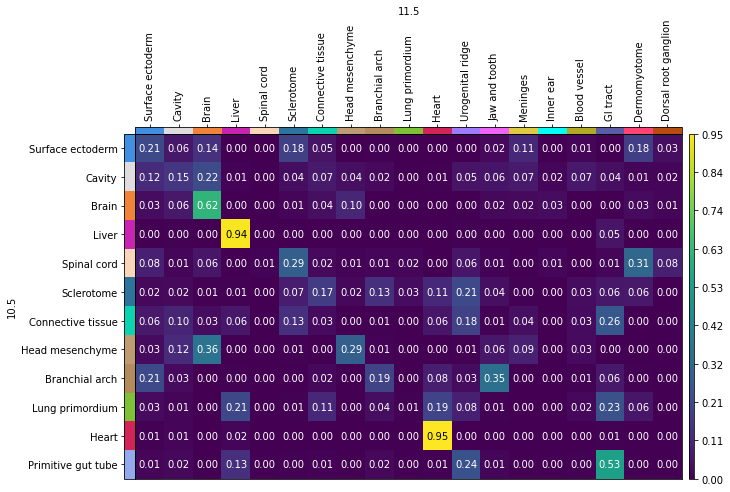

In [9]:
stp.cell_transition(source=10.5, target=11.5, source_groups={"annotation": source_ordered_2}, target_groups={"annotation": target_ordered_2}, forward=True)
mpl.cell_transition(stp, fontsize=10, figsize=(8,8))

## Pushing cells across space and time

Next, we can visualize the predicted spatial destination of the cells. We can do this on a single-cell level or on any aggregation. Here, we focus on the heart.

In [10]:
cell_type = "Heart"

In [11]:
for (start, end), prob in stp.problems.items():
    stp.push(start=start, end=end, data="annotation", subset=cell_type, key_added = f"{cell_type}_mapping_{end}")

In the first row we plot the spatial locations of the `Heart` cells in each time point. <br>
In the second row  we show the result projected onto the the spatial coordinates.

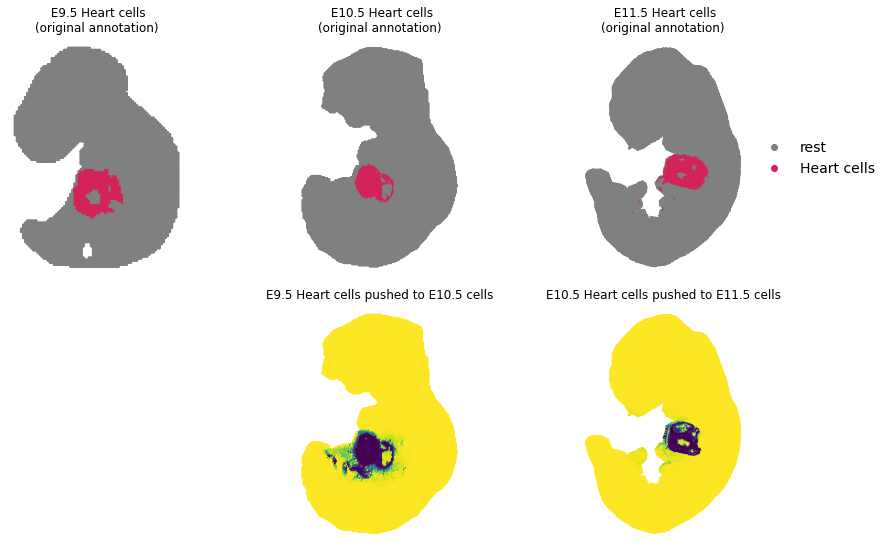

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(14,8))
timepoints = [9.5, 10.5, 11.5]
for i, tp in enumerate(timepoints):
    sq.pl.spatial_scatter(
        adata[adata.obs["time"].isin([tp])].copy(), 
        color=[f"{cell_type}_annotation"],
        title = [f" E{tp} {cell_type} cells\n(original annotation)"],
        frameon=False,
        shape=None,
        library_id="hires",
        legend_fontsize = 14,
        ax=axs[0, i]
    )
    if i > 0:
        sq.pl.spatial_scatter(
            stp[tp,tp+1].adata if i<2 else stp[tp-1,tp].adata_tgt, 
            color=[f"{cell_type}_mapping_{tp}"],
            title = [f"E{timepoints[i-1]} {cell_type} cells pushed to E{timepoints[i]} cells"], 
            frameon=False,
            shape=None,
            library_id="hires",
            legend_fontsize = 14,
            cmap="viridis_r",
            colorbar=False,
            ax=axs[1, i]
        )
        
    if i < 2:
        axs[0, i].legend().remove()
    
plt.tight_layout()
axs[1, 0].remove()
plt.show()